In [2]:
"""
Forward Simulation of Gradiometry Data for Magnetic Vector Models
=================================================================

Here we use the module *SimPEG.potential_fields.magnetics* to predict magnetic
gradiometry data for magnetic vector models. The simulation is performed on a
Tree mesh. For this tutorial, we focus on the following:

    - How to define the survey when we want to measured multiple field components
    - How to predict magnetic data in the case of remanence
    - How to include surface topography
    - How to construct tree meshes based on topography and survey geometry
    - The units of the physical property model and resulting data

"""

'\nForward Simulation of Gradiometry Data for Magnetic Vector Models\n=================================================================\n\nHere we use the module *SimPEG.potential_fields.magnetics* to predict magnetic\ngradiometry data for magnetic vector models. The simulation is performed on a\nTree mesh. For this tutorial, we focus on the following:\n\n    - How to define the survey when we want to measured multiple field components\n    - How to predict magnetic data in the case of remanence\n    - How to include surface topography\n    - How to construct tree meshes based on topography and survey geometry\n    - The units of the physical property model and resulting data\n\n\n'

In [1]:
#########################################################################
# Import Modules
# --------------
#

import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder, mat_utils
from SimPEG import maps
from SimPEG.potential_fields import magnetics

# sphinx_gallery_thumbnail_number = 2

In [3]:
#############################################
# Topography
# ----------
#
# Here we define surface topography as an (N, 3) numpy array. Topography could
# also be loaded from a file.
#

[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = np.exp(-(x_topo**2 + y_topo**2) / 80**2)
#z_topo = -15 * np.exp(-(x_topo**2 + y_topo**2) / 80**2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
xyz_topo = np.c_[x_topo, y_topo, z_topo]

In [4]:
#############################################
# Defining the Survey
# -------------------
#
# Here, we define survey that will be used for the simulation. Magnetic
# surveys are simple to create. The user only needs an (N, 3) array to define
# the xyz locations of the observation locations, the list of field components
# which are to be modeled and the properties of the Earth's field.
#

# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-80.0, 80.0, 17)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10  # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as strings within
# a list. Here we measure the x, y and z derivatives of the Bz anomaly at
# each observation location.
components = ["bxz", "byz", "bzz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
field_inclination = 60
field_declination = 30
field_strength = 50000
inducing_field = (field_strength, field_inclination, field_declination)

source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

C:\Users\wende\AppData\Local\Temp\ipykernel_18888\3843279128.py:37: FutureWarning: SourceField has been deprecated, please use UniformBackgroundField. It will be removed in version 0.19.0 of SimPEG.
  source_field = magnetics.sources.SourceField(


In [5]:
##########################################################
# Defining an OcTree Mesh
# -----------------------
#
# Here, we create the OcTree mesh that will be used to predict magnetic
# gradiometry data for the forward simuulation.
#

dx = 5  # minimum cell width (base mesh cell width) in x
dy = 5  # minimum cell width (base mesh cell width) in y
dz = 5  # minimum cell width (base mesh cell width) in z

x_length = 240.0  # domain width in x
y_length = 240.0  # domain width in y
z_length = 120.0  # domain width in y

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN")

# Refine based on surface topography
mesh = refine_tree_xyz(
    mesh, xyz_topo, octree_levels=[2, 2], method="surface", finalize=False
)

# Refine box base on region of interest
xp, yp, zp = np.meshgrid([-100.0, 100.0], [-100.0, 100.0], [-80.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]

mesh = refine_tree_xyz(mesh, xyz, octree_levels=[2, 2], method="box", finalize=False)

mesh.finalize()

C:\Users\wende\AppData\Local\Temp\ipykernel_18888\2138304723.py:29: DeprecationWarning: The surface option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_surface` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(
C:\Users\wende\AppData\Local\Temp\ipykernel_18888\2138304723.py:37: DeprecationWarning: The box option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_bounding_box` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(mesh, xyz, octree_levels=[2, 2], method="box", finalize=False)


In [9]:
#########################################################
# Create Magnetic Vector Intensity Model (MVI)
# --------------------------------------------
#
# Magnetic vector models are defined by three-component effective
# susceptibilities. To create a magnetic vector
# model, we must
#
#     1) Define the magnetic susceptibility for each cell. Then multiply by the
#     unit vector direction of the inducing field. (induced contribution)
#     2) Define the remanent magnetization vector for each cell and normalize
#     by the magnitude of the Earth's field (remanent contribution)
#     3) Sum the induced and remanent contributions
#     4) Define as a vector np.r_[chi_1, chi_2, chi_3]
#
#

# Define susceptibility values for each unit in SI
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

# Find cells active in the forward modeling (cells below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=3 * nC)  # model has 3 parameters for each cell

# Define susceptibility for each cell
susceptibility_model = background_susceptibility * np.ones(ind_active.sum())
ind_sphere = model_builder.get_indices_sphere(np.r_[0.0, 0.0, -45.0], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
susceptibility_model[ind_sphere] = sphere_susceptibility

# Compute the unit direction of the inducing field in Cartesian coordinates
field_direction = mat_utils.dip_azimuth2cartesian(field_inclination, field_declination)

# Multiply susceptibility model to obtain the x, y, z components of the
# effective susceptibility contribution from induced magnetization.
susceptibility_model = np.outer(susceptibility_model, field_direction)


In [ ]:
# Define the effective susceptibility contribution for remanent magnetization to have a
# magnitude of 0.006 SI, with inclination -45 and declination 90
remanence_inclination = -45.0
remanence_declination = 90.0
remanence_susceptibility = 0.01

remanence_model = np.zeros(np.shape(susceptibility_model))
effective_susceptibility_sphere = (
    remanence_susceptibility
    * mat_utils.dip_azimuth2cartesian(remanence_inclination, remanence_declination)
)
remanence_model[ind_sphere, :] = effective_susceptibility_sphere

# Define effective susceptibility model as a vector np.r_[chi_x, chi_y, chi_z]
plotting_model = susceptibility_model + remanence_model
model = mkvc(plotting_model)

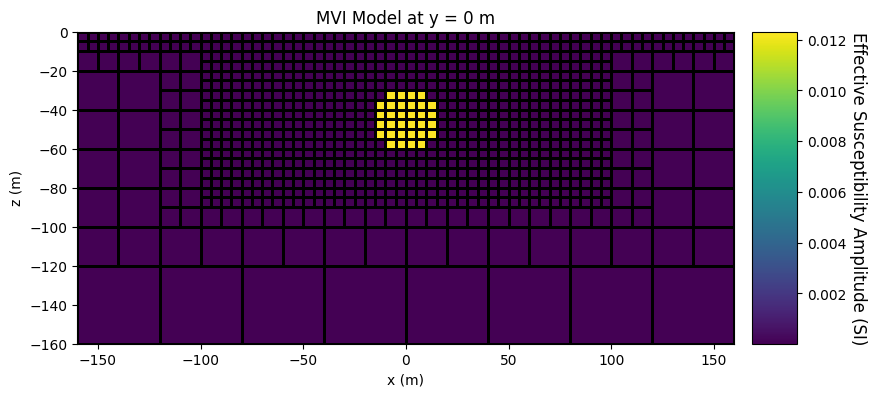

In [7]:
# Plot Effective Susceptibility Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
plotting_model = np.sqrt(np.sum(plotting_model, axis=1) ** 2)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * plotting_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(plotting_model), np.max(plotting_model)),
)
ax1.set_title("MVI Model at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(plotting_model), vmax=np.max(plotting_model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label(
    "Effective Susceptibility Amplitude (SI)", rotation=270, labelpad=15, size=12
)

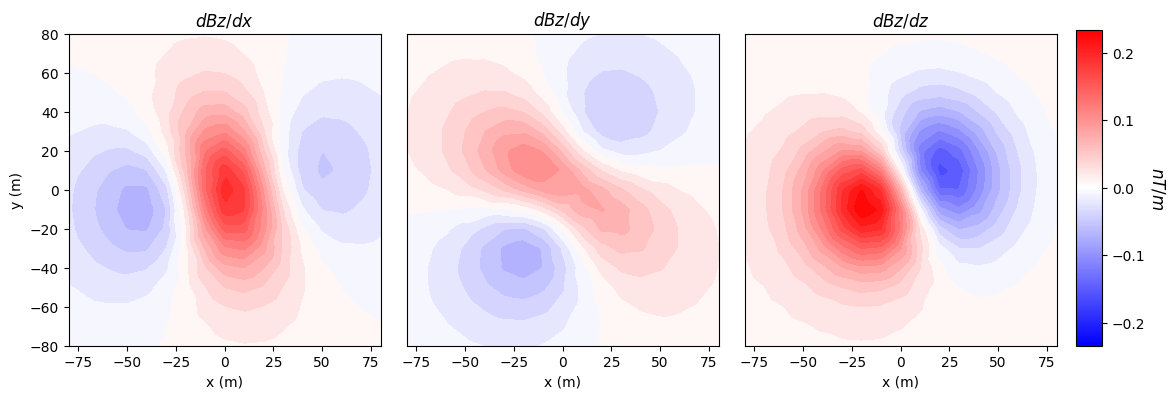

In [8]:
###################################################################
# Simulation: Gradiometry Data for an MVI Model
# ---------------------------------------------
#
# Here we predict magnetic gradiometry data for an effective susceptibility model
# in the case of remanent magnetization.
#

# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    chiMap=model_map,
    ind_active=ind_active,
    model_type="vector",
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
dpred = simulation.dpred(model)
n_data = len(dpred)

# Plot
fig = plt.figure(figsize=(13, 4))
v_max = np.max(np.abs(dpred))

ax1 = fig.add_axes([0.1, 0.15, 0.25, 0.78])
plot2Ddata(
    receiver_list[0].locations,
    dpred[0:n_data:3],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("$dBz/dx$")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.36, 0.15, 0.25, 0.78])
cplot2 = plot2Ddata(
    receiver_list[0].locations,
    dpred[1:n_data:3],
    ax=ax2,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot2[0].set_clim((-v_max, v_max))
ax2.set_title("$dBz/dy$")
ax2.set_xlabel("x (m)")
ax2.set_yticks([])

ax3 = fig.add_axes([0.62, 0.15, 0.25, 0.78])
cplot3 = plot2Ddata(
    receiver_list[0].locations,
    dpred[2:n_data:3],
    ax=ax3,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
cplot3[0].set_clim((-v_max, v_max))
ax3.set_title("$dBz/dz$")
ax3.set_xlabel("x (m)")
ax3.set_yticks([])

ax4 = fig.add_axes([0.88, 0.15, 0.02, 0.79])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax4, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT/m$", rotation=270, labelpad=15, size=12)

plt.show()
